In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scienceplots as scp
import seaborn as sns

import numpy as np
import torch

matplotlib.rcParams['figure.figsize'] = (20, 6)

import sys
sys.path.append("..")

from argparse import Namespace
from main import main, parse_args
from utils.plotting import *
from utils.analysis import process_outputs, get_change_responses, get_omission_responses

from utils.data import load_results_files

import warnings
warnings.filterwarnings('ignore')

import os

In [27]:
# modification on the usual raincloud plot function for the purposes of this figure

def raincloud_plot(ax, familiar_responses, novel_responses, xlabels=None, marker_sz=10., color_scheme=2, third_cond=None):
    # color schemes: 0 -> familiar, familiar, 1 -> novel, novel, 2 -> familiar, novel

    if xlabels is None:
        xlabels = ['Familiar', 'Novel']

    # Create a list of colors for each component of the raincloud
    num_cond = 2 if third_cond is None else 3
    if color_scheme == 0:
        boxplots_colors = ['darkorange']*num_cond
        median_colors = ['orangered']*num_cond
        violin_colors = ['orange']*num_cond
        scatter_colors = ['darkorange']*num_cond
    elif color_scheme == 1:
        boxplots_colors = ['darkblue']*num_cond
        median_colors = ['navy']*num_cond
        violin_colors = ['cornflowerblue']*num_cond
        scatter_colors = ['darkblue']*num_cond
    else:
        boxplots_colors = ['darkorange', 'darkblue']
        median_colors = ['orangered', 'navy']
        violin_colors = ['orange', 'cornflowerblue']
        scatter_colors = ['darkorange', 'darkblue']

    # Boxplot data
    data = [familiar_responses, novel_responses] if third_cond is None else [familiar_responses, novel_responses, third_cond]
    bp = ax.boxplot(data, patch_artist = True, vert = True, showmeans=True, showfliers=False,
                   meanprops={'markersize': marker_sz*2, 'markerfacecolor': 'teal'})

    # Change to the desired color and add transparency
    for patch, color in zip(bp['boxes'], boxplots_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.35)
        patch.set_linewidth(2.0)
        patch.set_linestyle('solid')
    
    for patch, color in zip(bp['medians'], median_colors):
        patch.set_color(color)
        patch.set_linewidth(2.5)    

    # Violinplot data
    vp = ax.violinplot(data, points=500, 
                   showmeans=False, showextrema=False, showmedians=False, vert=True)
    
    for idx, b in enumerate(vp['bodies']):
        # Get the center of the plot
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # Modify it so we only see the upper half of the violin plot
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], idx+1, idx+2)
        # Change to the desired color
        b.set_color(violin_colors[idx])
        b.set_alpha(0.3)    

    # Scatterplot data
    for idx, features in enumerate(data):
        # Add jitter effect so the features do not overlap on the y-axis
        y = np.full(len(features), idx + .7)
        idxs = np.arange(len(y))
        out = y.astype(float)
        out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
        y = out
        ax.scatter(y, features, s=marker_sz, c=scatter_colors[idx])

    ax.set_xticks(np.arange(1,num_cond+1,1), xlabels)  # Set text labels.
    ax.set_ylabel('Average response')

In [2]:
# load results for the full model
active_args, active_change, active_omission, active_progress = load_results_files("../results/main_model", "perception_action")
active_args = Namespace(**active_args)

In [16]:
# load results for the no energy model
energy_args, energy_change, energy_omission, energy_progress = load_results_files("../results/main_model", "no_energy")
energy_args = Namespace(**energy_args)

#### No inhibition

In [12]:
noinh_args, noinh_change, noinh_omission, noinh_progress = load_results_files(f"../results/main_model", "no_inh")
noinh_args = Namespace(**noinh_args)

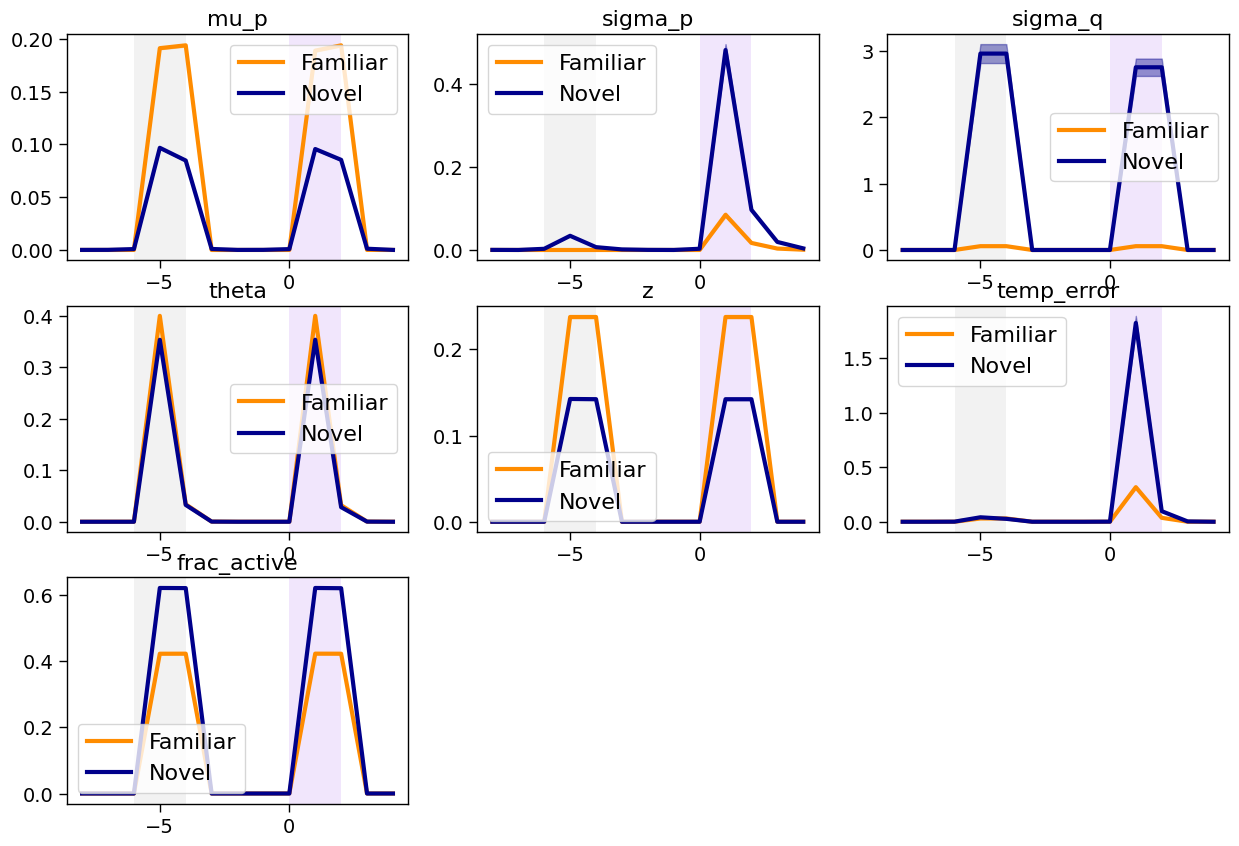

In [31]:
# Change Responses

with plt.style.context(['nature', 'notebook']):

    noinh_change_fig = plt.figure(figsize=(15, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(noinh_change['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        _ = plot_trial_responses(noinh_args, ax, noinh_change['familiar'][pop], noinh_change['novel'][pop], normalize=False)
        _ = ax.set_title(f"{pop}")
        _ = ax.legend()

In [32]:
noinh_change_fig.savefig("../figures/figure_6/noinh_change_responses.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

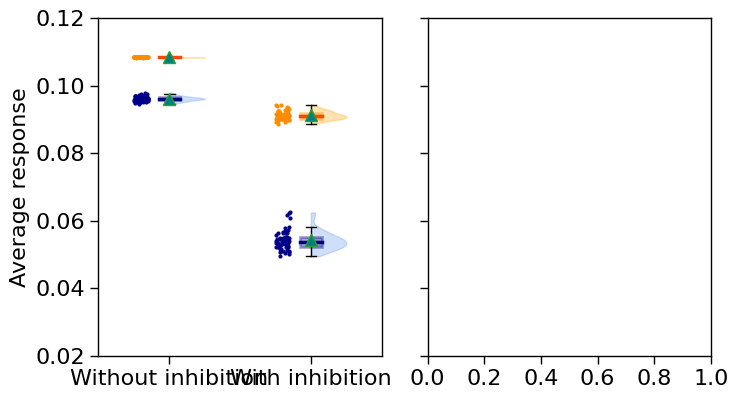

In [15]:
# Raincloud plots

with plt.style.context(['nature', 'notebook']):

    fam_pa = active_change['familiar_means']['theta'].detach()
    nov_pa = active_change['novel_means']['theta'].detach()

    fam_noinh = noinh_change['familiar_means']['theta'].detach()
    nov_noinh = noinh_change['novel_means']['theta'].detach()
    
    theta_rain, theta_rain_ax = plt.subplots(1, 2, figsize=(7, 4), sharey=True)
    plt.tight_layout()

    # we will average pre-change and change response since theta doesn't have a change response anyways

    raincloud_plot(theta_rain_ax[0], fam_noinh.mean(0).mean(-1), fam_pa.mean(0).mean(-1), xlabels=['Without inhibition', 'With inhibition'], marker_sz=4, color_scheme=0)
    raincloud_plot(theta_rain_ax[0], nov_noinh.mean(0).mean(-1), nov_pa.mean(0).mean(-1), xlabels=['Without inhibition', 'With inhibition'], marker_sz=4, color_scheme=1)

    theta_rain_ax[0].set_ylim([0.02, 0.12])

In [33]:
theta_rain.savefig("../figures/figure_6/theta_rain_noinh.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

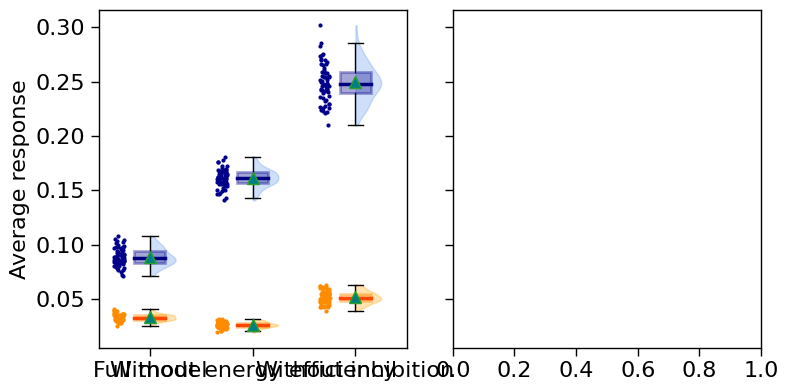

In [28]:
# Raincloud plots for the temporal prediction error

with plt.style.context(['nature', 'notebook']):

    fam_pa = active_change['familiar_means']['temp_error'].detach()
    nov_pa = active_change['novel_means']['temp_error'].detach()

    fam_noinh = noinh_change['familiar_means']['temp_error'].detach()
    nov_noinh = noinh_change['novel_means']['temp_error'].detach()

    fam_energy = energy_change['familiar_means']['temp_error'].detach()
    nov_energy = energy_change['novel_means']['temp_error'].detach()

    
    temp_rain, temp_rain_ax = plt.subplots(1, 2, figsize=(7.5, 4), sharey=True)
    plt.tight_layout()

    # we will average pre-change and change response since theta doesn't have a change response anyways

    raincloud_plot(temp_rain_ax[0], fam_pa.mean(0).mean(-1), fam_energy.mean(0).mean(-1), third_cond=fam_noinh.mean(0).mean(-1), xlabels=['Full model', 'Without energy efficiency', 'Without inhibition'], marker_sz=4, color_scheme=0)
    raincloud_plot(temp_rain_ax[0], nov_pa.mean(0).mean(-1), nov_energy.mean(0).mean(-1), third_cond=nov_noinh.mean(0).mean(-1), xlabels=['Full model', 'Without energy efficiency', 'Without inhibition'], marker_sz=4, color_scheme=1)

    #theta_rain_ax[0].set_ylim([0.02, 0.12])

In [34]:
temp_rain.savefig("../figures/figure_6/temp_rain_noinh.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

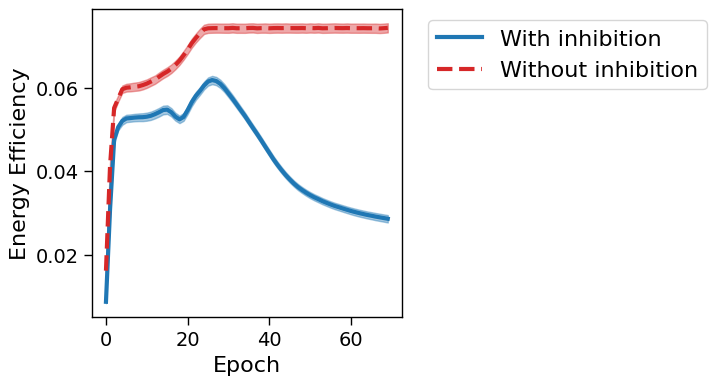

In [30]:
# Energy efficiency training progress

with plt.style.context(['nature', 'notebook']):

    energy_loss_fig, energy_loss_ax = plt.subplots(figsize=(4, 4))

    noinh_mean = noinh_progress['energy'].mean(0)
    noinh_sem = noinh_progress['energy'].std(0) / np.sqrt(noinh_progress['energy'].shape[0])

    full_mean = active_progress['energy'].mean(0)
    full_sem = active_progress['energy'].std(0) / np.sqrt(active_progress['energy'].shape[0])


    x_range = np.arange(len(full_mean))
    energy_loss_ax.plot(x_range, full_mean, label='With inhibition', color='tab:blue', linewidth=3.0)
    energy_loss_ax.plot(x_range, noinh_mean, '--', label='Without inhibition', color='tab:red', linewidth=3.0)

    energy_loss_ax.fill_between(x_range,
                                full_mean - full_sem,
                                full_mean + full_sem,
                                color='tab:blue', alpha=0.4)
    energy_loss_ax.fill_between(x_range,
                                noinh_mean - noinh_sem,
                                noinh_mean + noinh_sem,
                                color='tab:red', alpha=0.4)
    energy_loss_ax.tick_params(axis='both', which='major', labelsize=14)

    energy_loss_ax.set_xlabel('Epoch')
    energy_loss_ax.set_ylabel('Energy Efficiency')
    energy_loss_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [35]:
energy_loss_fig.savefig("../figures/figure_6/energy_loss_noinh.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

#### No disinhibition

In [36]:
nodis_args, nodis_change, nodis_omission, nodis_progress = load_results_files(f"../results/main_model", "no_disinh")
nodis_args = Namespace(**nodis_args)

_, strong_dis_change, strong_dis_omission, strong_dis_progress = load_results_files(f"../results/main_model", "strong_disinh")

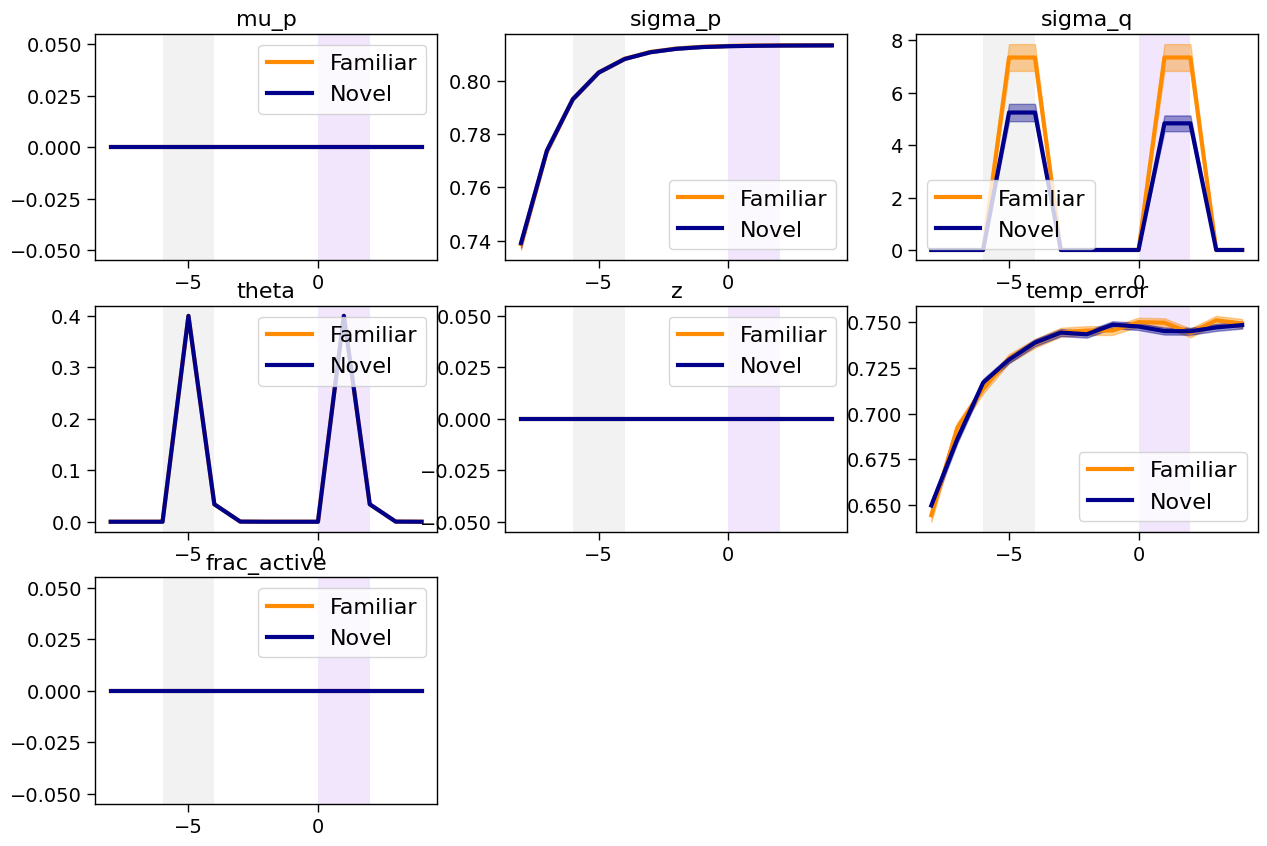

In [63]:
# Change Responses

with plt.style.context(['nature', 'notebook']):

    nodis_change_fig = plt.figure(figsize=(15, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(nodis_change['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        _ = plot_trial_responses(nodis_args, ax, nodis_change['familiar'][pop], nodis_change['novel'][pop], normalize=False)
        _ = ax.set_title(f"{pop}")
        _ = ax.legend()

In [64]:
nodis_change_fig.savefig("../figures/figure_6/nodis_change_responses.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

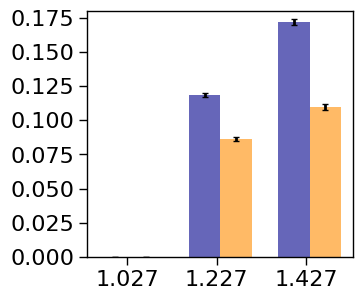

In [65]:
# Fraction actives bar plot

# Fraction active bar plot

with plt.style.context(['nature', 'notebook']):

    fam_len, nov_len = len(active_change['familiar_means']['frac_active']), len(active_change['novel_means']['frac_active'])
    fam_nd_len, nov_ni_len = len(nodis_change['familiar_means']['frac_active']), len(nodis_change['novel_means']['frac_active'])
    fam_sd_len, nov_sd_len = len(strong_dis_change['familiar_means']['frac_active']), len(strong_dis_change['novel_means']['frac_active'])

    # fraction active in the full model case average across prechange and change
    pa_fam, pa_fam_err = compute_population_stats(active_change['familiar_means']['frac_active'].mean(-1).numpy(), alpha=0.000000001)
    pa_nov, pa_nov_err = compute_population_stats(active_change['novel_means']['frac_active'].mean(-1).numpy(), alpha=0.000000001)

    # fraction active in the no disinhibition case averaged across prechange and change
    nodis_fam, nodis_fam_err = compute_population_stats(nodis_change['familiar_means']['frac_active'].mean(-1).numpy(), alpha=0.000000001)
    nodis_nov, nodis_nov_err = compute_population_stats(nodis_change['novel_means']['frac_active'].mean(-1).numpy(), alpha=0.000000001)

    # fraction active in the strong disinhibition case averaged across prechange and change
    sd_fam, sd_fam_err = compute_population_stats(strong_dis_change['familiar_means']['frac_active'].mean(-1).numpy(), alpha=0.000000001)
    sd_nov, sd_nov_err = compute_population_stats(strong_dis_change['novel_means']['frac_active'].mean(-1).numpy(), alpha=0.000000001)

    frac_fig, frac_ax = plt.subplots(figsize=(3.5, 3))

    frac_ax.bar(
        x = [1., 1.2, 1.4],
        height=[nodis_nov, pa_nov, sd_nov],
        yerr=[nodis_nov_err, pa_nov_err, sd_nov_err],
        width=0.07,
        align='center',
        color=(NOV_CLR, NOV_CLR, NOV_CLR),
        alpha=0.6,
        capsize=2,
        label='Novel'
    )

    frac_ax.bar(
        x = [1.07, 1.27, 1.47],
        height=[nodis_fam, pa_fam, sd_fam],
        yerr=[nodis_fam_err, pa_fam_err, sd_fam_err],
        width=0.07,
        align='center',
        color=(FAM_CLR, FAM_CLR, FAM_CLR),
        alpha=0.6,
        capsize=2,
        label='Familiar'
    )

    frac_ax.set_xticks([1.027, 1.227, 1.427])
    #frac_ax.set_xticklabels(['No\ndisinhibition', 'Weak\ndisinhibition', 'Strong\ndisinhibition'])
    
    frac_ax.set_ylim([0., 0.18])
    #frac_ax.set_xlim([0.9, 1.5])
    #frac_ax.legend()

    plt.tight_layout()
    

In [66]:
frac_fig.savefig("../figures/figure_6/nodis_frac_actives.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

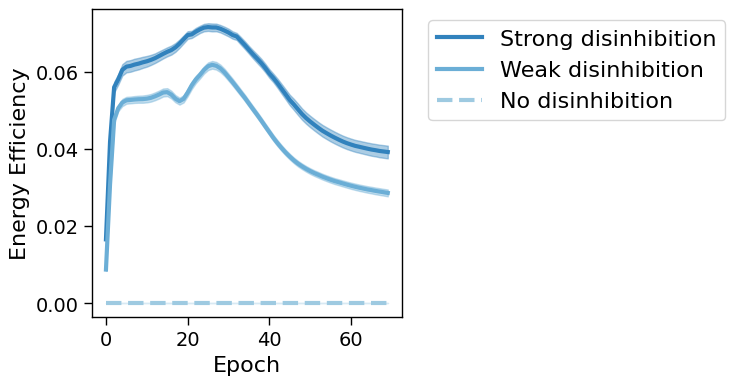

In [67]:
# Energy efficiency for different disinhibition cases

with plt.style.context(['nature', 'notebook']):

    energy_loss_fig, energy_loss_ax = plt.subplots(figsize=(4, 4))

    nodis_mean = nodis_progress['energy'].mean(0)
    nodis_sem = nodis_progress['energy'].std(0) / np.sqrt(nodis_progress['energy'].shape[0])

    full_mean = active_progress['energy'].mean(0)
    full_sem = active_progress['energy'].std(0) / np.sqrt(active_progress['energy'].shape[0])

    sd_mean = strong_dis_progress['energy'].mean(0)
    sd_sem = strong_dis_progress['energy'].std(0) / np.sqrt(strong_dis_progress['energy'].shape[0])

    clrs = sns.color_palette('tab20c')

    x_range = np.arange(len(full_mean))
    energy_loss_ax.plot(x_range, sd_mean, label='Strong disinhibition', color=clrs[0], linewidth=3.0)
    energy_loss_ax.plot(x_range, full_mean, label='Weak disinhibition', color=clrs[1], linewidth=3.0)
    energy_loss_ax.plot(x_range, nodis_mean, '--', label='No disinhibition', color=clrs[2], linewidth=3.0)

    energy_loss_ax.fill_between(x_range,
                                sd_mean - sd_sem,
                                sd_mean + sd_sem,
                                color=clrs[0], alpha=0.4)
    energy_loss_ax.fill_between(x_range,
                                full_mean - full_sem,
                                full_mean + full_sem,
                                color=clrs[1], alpha=0.4)
    energy_loss_ax.fill_between(x_range,
                                nodis_mean - nodis_sem,
                                nodis_mean + nodis_sem,
                                color=clrs[2], alpha=0.4)
    energy_loss_ax.tick_params(axis='both', which='major', labelsize=14)

    energy_loss_ax.set_xlabel('Epoch')
    energy_loss_ax.set_ylabel('Energy Efficiency')
    energy_loss_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [68]:
energy_loss_fig.savefig("../figures/figure_6/energy_loss_dis_progress.pdf", dpi=600, bbox_inches="tight", pad_inches=0)